<a href="https://colab.research.google.com/github/nasirbashak/Plant-the-future/blob/master/Normal_Regression_Model_with_40_MAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install tensorflow==2.0.0b1
!pip install tensorflow==2.1.0

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
import pandas as pd
print(tf.__version__)

2.1.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
df = pd.read_csv("/content/drive/My Drive/Plant the future/datasets/Traffic_density_day_by_day_2000_to_2019.csv")
df.head()

,day_stamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2000-1,3986,1617,8890,1201,1522,6422,1547,910,2094,670,6298,1738,402,766,1226,503,2298,804,1171,3123,1719,1889,928,1409,1823,677,4832,496,971,6445,2037,324,1138,511,1362,3759,683,326,474,...,1743,1562,723,1596,1724,1622,1870,9942,9950,1605,1140,9915,8679,745,545,31,1773,1634,1681,796,2285,1622,1856,1629,616,1951,5999,166,4939,235,1046,6217,564,1585,1559,1363,1879,323,484,696
1,2000-2,3912,1616,8888,1209,1431,6427,1651,929,2083,624,6301,1723,370,779,1275,518,2327,780,1141,3135,1720,1959,932,1503,1810,627,4832,429,1042,6449,2047,288,1087,493,1298,3755,716,316,453,...,1759,1620,719,1540,1619,1614,1857,9946,9954,1584,1152,9919,8687,757,568,35,1813,1574,1684,767,2279,1637,1806,1537,614,1967,5998,215,4938,210,1065,6204,549,1539,1630,1255,1906,308,474,642
2,2000-3,3846,1639,8886,1278,1383,6429,1727,971,2042,603,6302,1710,336,761,1314,504,2302,727,1128,3131,1732,2024,922,1598,1782,601,4831,380,1036,6457,2176,289,1042,524,1278,3761,772,326,438,...,1775,1653,681,1594,1564,1577,1845,9949,9963,1533,1140,9918,8696,766,595,58,1797,1498,1686,718,2275,1639,1732,1465,580,1970,5993,221,4943,190,1179,6193,550,1454,1645,1182,1920,299,503,618
3,2000-4,3780,1620,8880,1399,1350,6432,1717,1005,1983,555,6295,1716,333,784,1384,514,2275,684,1102,3123,1755,2067,906,1630,1785,693,4836,337,1067,6471,2220,302,998,520,1336,3773,838,331,402,...,1833,1729,654,1538,1463,1562,1801,9952,9976,1440,1110,9923,8699,765,627,90,1784,1412,1689,695,2263,1636,1656,1403,544,1971,5985,229,4959,169,1202,6184,566,1408,1649,1121,1966,311,549,557
4,2000-5,3719,1591,8877,1524,1290,6449,1736,999,1952,536,6292,1724,333,786,1406,530,2234,714,1104,3116,1858,2052,890,1636,1791,796,4841,302,1052,6472,2263,291,960,508,1285,3775,885,330,387,...,1913,1790,669,1451,1406,1541,1791,9957,9986,1395,1063,9923,8703,708,611,113,1777,1361,1692,693,2261,1646,1575,1306,543,1985,5974,260,4969,144,1191,6174,574,1366,1662,1173,1952,311,609,513


In [0]:
#df.rename(columns={"Unnamed: 0":"day_stamp"},inplace=True)

In [0]:
df.head()

,day_stamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2000-1,3986,1617,8890,1201,1522,6422,1547,910,2094,670,6298,1738,402,766,1226,503,2298,804,1171,3123,1719,1889,928,1409,1823,677,4832,496,971,6445,2037,324,1138,511,1362,3759,683,326,474,...,1743,1562,723,1596,1724,1622,1870,9942,9950,1605,1140,9915,8679,745,545,31,1773,1634,1681,796,2285,1622,1856,1629,616,1951,5999,166,4939,235,1046,6217,564,1585,1559,1363,1879,323,484,696
1,2000-2,3912,1616,8888,1209,1431,6427,1651,929,2083,624,6301,1723,370,779,1275,518,2327,780,1141,3135,1720,1959,932,1503,1810,627,4832,429,1042,6449,2047,288,1087,493,1298,3755,716,316,453,...,1759,1620,719,1540,1619,1614,1857,9946,9954,1584,1152,9919,8687,757,568,35,1813,1574,1684,767,2279,1637,1806,1537,614,1967,5998,215,4938,210,1065,6204,549,1539,1630,1255,1906,308,474,642
2,2000-3,3846,1639,8886,1278,1383,6429,1727,971,2042,603,6302,1710,336,761,1314,504,2302,727,1128,3131,1732,2024,922,1598,1782,601,4831,380,1036,6457,2176,289,1042,524,1278,3761,772,326,438,...,1775,1653,681,1594,1564,1577,1845,9949,9963,1533,1140,9918,8696,766,595,58,1797,1498,1686,718,2275,1639,1732,1465,580,1970,5993,221,4943,190,1179,6193,550,1454,1645,1182,1920,299,503,618
3,2000-4,3780,1620,8880,1399,1350,6432,1717,1005,1983,555,6295,1716,333,784,1384,514,2275,684,1102,3123,1755,2067,906,1630,1785,693,4836,337,1067,6471,2220,302,998,520,1336,3773,838,331,402,...,1833,1729,654,1538,1463,1562,1801,9952,9976,1440,1110,9923,8699,765,627,90,1784,1412,1689,695,2263,1636,1656,1403,544,1971,5985,229,4959,169,1202,6184,566,1408,1649,1121,1966,311,549,557
4,2000-5,3719,1591,8877,1524,1290,6449,1736,999,1952,536,6292,1724,333,786,1406,530,2234,714,1104,3116,1858,2052,890,1636,1791,796,4841,302,1052,6472,2263,291,960,508,1285,3775,885,330,387,...,1913,1790,669,1451,1406,1541,1791,9957,9986,1395,1063,9923,8703,708,611,113,1777,1361,1692,693,2261,1646,1575,1306,543,1985,5974,260,4969,144,1191,6174,574,1366,1662,1173,1952,311,609,513


Series shape (7305,)
Time shape (7305,)


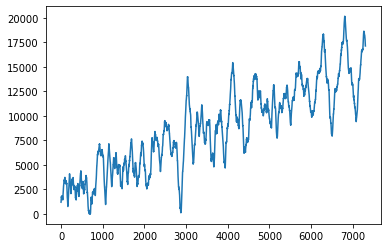

In [0]:
df.iloc[:,4].plot()
series = df.iloc[:,4]
time = np.array(range(len(series)))
print("Series shape",series.shape)
print("Time shape",time.shape)

In [0]:
series = np.array(series)

In [0]:
split_time = 5600
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([

  tf.keras.layers.Dense(30, activation="relu",input_shape=[None, 1]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




NameError: ignored

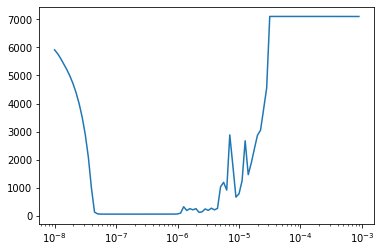

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [0]:
bestLr = history.history['lr'][np.argmin(history.history['loss'])]
bestLr

1.9952623e-07

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=64, batch_size=256, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([


  tf.keras.layers.Dense(30, activation="relu", input_shape=[None,1]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])


optimizer = tf.keras.optimizers.SGD(lr=bestLr, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/250
22/22 [==============================] - 2s 86ms/step - loss: 3754.0765 - mae: 3749.7800
Epoch 2/250
22/22 [==============================] - 1s 65ms/step - loss: 554.3814 - mae: 556.3528
Epoch 3/250
22/22 [==============================] - 1s 63ms/step - loss: 77.1575 - mae: 77.7898
Epoch 4/250
22/22 [==============================] - 1s 67ms/step - loss: 73.4115 - mae: 74.4398
Epoch 5/250
22/22 [==============================] - 1s 67ms/step - loss: 41.9259 - mae: 42.5267
Epoch 6/250
22/22 [==============================] - 1s 67ms/step - loss: 42.9704 - mae: 43.6438
Epoch 7/250
22/22 [==============================] - 1s 65ms/step - loss: 38.2243 - mae: 38.8219
Epoch 8/250
22/22 [==============================] - 1s 68ms/step - loss: 37.0259 - mae: 37.5885
Epoch 9/250
22/22 [==============================] - 1s 66ms/step - loss: 35.9157 - mae: 36.4180
Epoch 10/250
22/22 [==============================] - 1s 68ms/step - loss: 33.6966 - mae: 34.2068
Epoch 11/250
22/22 [===

<Figure size 432x288 with 0 Axes>

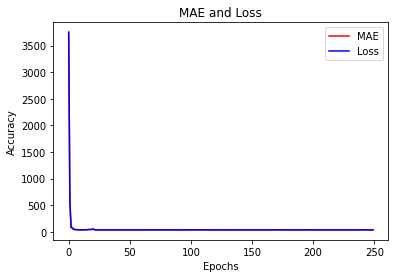

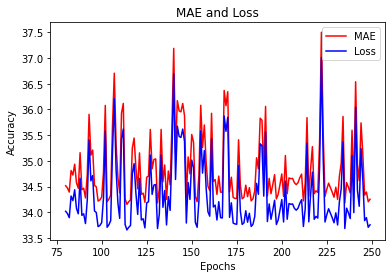

<Figure size 432x288 with 0 Axes>

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[80:]
mae_zoom = mae[80:]
loss_zoom = loss[80:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1,0]

In [0]:
rnn_forecast2 = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast2 = rnn_forecast2[ window_size:split_time, -1, 0]

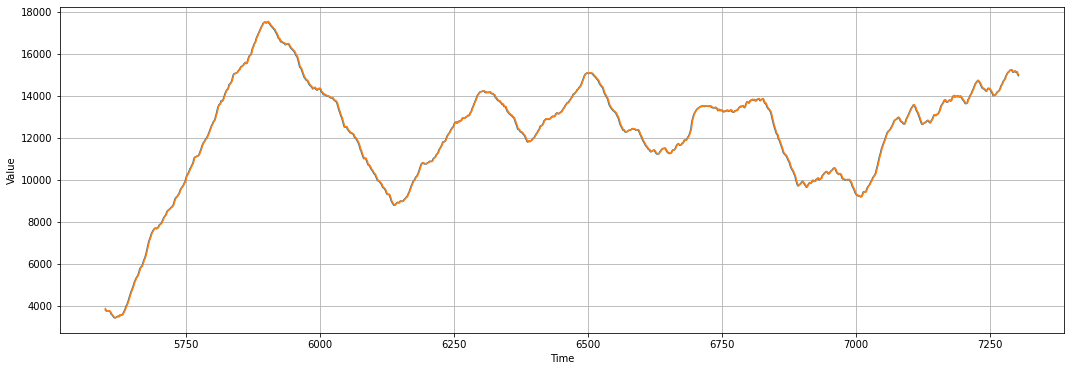

In [0]:
plt.figure(figsize=(18, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

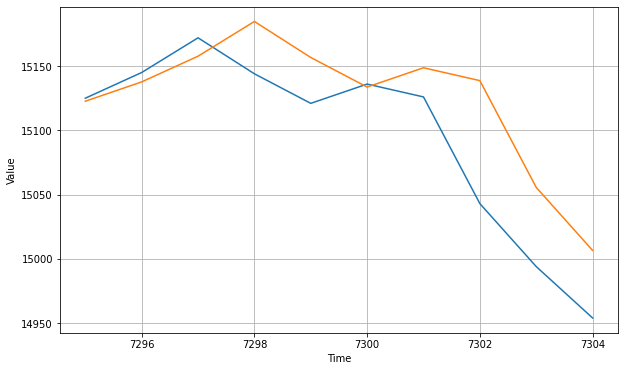

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid[-10:], x_valid[-10:])
plot_series(time_valid[-10:], rnn_forecast[-10:])

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

39.151142

In [0]:
print(rnn_forecast)

[ 3863.8577  3800.909   3775.9292 ... 15113.709  15030.775  14981.815 ]


In [0]:
model.save("/content/drive/My Drive/Plant the future/datasets/Regression_model_two_dense_layered.h5")

# After this open second file and test the predictions


In [0]:
loaded_model = tf.keras.models.load_model("/content/Regression_model_two_dense_layered.h5")

In [0]:
rnn_forecast = model_forecast(loaded_model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

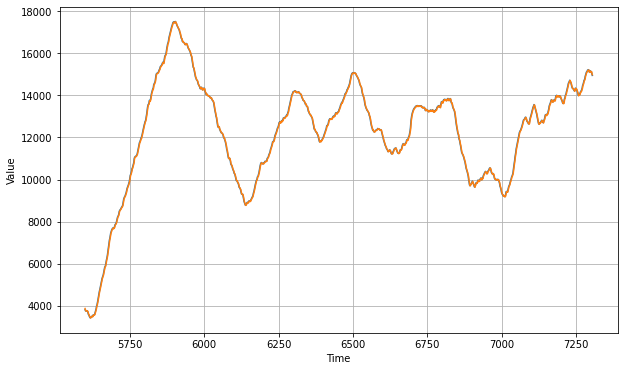

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast,format='-')

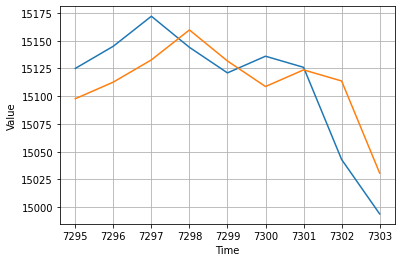

In [0]:
 plot_series(time[-10:-1], series[-10:-1])
plot_series(time[-10:-1], rnn_forecast[-10:-1],format='-')

In [0]:
tf.keras.metrics.mean_absolute_error(series[split_time :], rnn_forecast).numpy()

40.814663

Series shape (7305,)
Time shape (7305,)


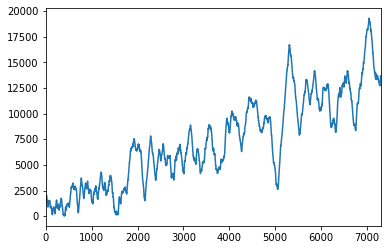

In [0]:
column = 100

df.iloc[:,column].plot()
series = df.iloc[:,column]
time = np.array(range(len(series)))
print("Series shape",series.shape)
print("Time shape",time.shape)

In [0]:
df.iloc[:,column].describe()

count     7305.000000
mean      7296.409446
std       4374.566871
min         49.000000
25%       3465.000000
50%       6751.000000
75%      10674.000000
max      19311.000000
Name: 99, dtype: float64

In [0]:
series = np.array(series)
time = np.array(time)
window_size = 64

In [0]:
series.shape

(7305,)

In [0]:
rnn_forecast = model_forecast(loaded_model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[:-1, -1, 0]
print("Shape of forecast",rnn_forecast.shape)

Shape of forecast (7241,)


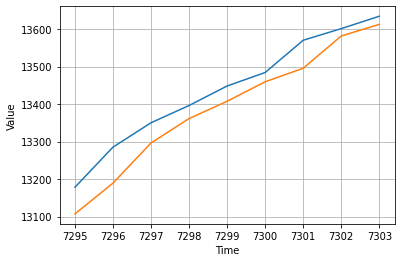

In [0]:
#plt.figure(figsize=(20, 12))
plot_series(time[-10:-1], series[-10:-1])
plot_series(time[-10:-1], rnn_forecast[-10:-1],format='-')

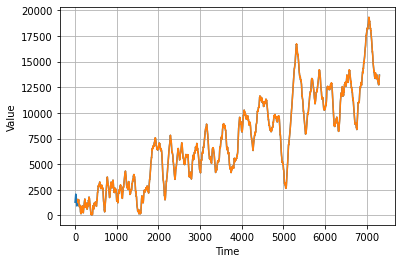

In [0]:
plot_series(time, series,format='-')
plot_series(time[window_size:], rnn_forecast,format='-')

In [0]:
tf.keras.metrics.mean_absolute_error(series[window_size:], rnn_forecast).numpy()

39.14699

In [0]:
1-(39.226772/7296.409446)

0.9946238252814191

In [0]:
rnn_forecast = model_forecast(loaded_model, series[7304-window_size:7304][...,np.newaxis], window_size)
#rnn_forecast = rnn_forecast[:-1, -1,0]
rnn_forecast.shape

(1, 64, 1)

In [0]:
rnn_forecast[0][-1][0]

13622.92

In [0]:
series[7304]

13691

In [0]:
time[7304]

7304